# Assignment 12

### 1.复习上课内容

### 2.回答以下理论问题

#### 1. 请写一下TF-IDF的计算公式

句子中某个词的TF-IDF权重 = 句子中这次词出现的次数 * log10（文档总数/出现这个词的文档数）

#### 2. LDA算法的基本假设是什么？

每个文档的主题都服从一个概率分布。  
每个主题的单词都服从一个概率分布。

#### 3. 在TextRank算法中构建图的权重是如何得到的？

两个词之间边的权重是这两个词向量的余弦距离。

#### 4. 什么是命名实体识别？ 有什么应用场景？

命名实体识别是指识别文本中具有特定意义的实体，包括人名、地名、组织名、动物名、植物名等等。识别出这些实体的名称，并且识别出这些实体的类别。  
命名实体识别可以用于知识图谱、文本理解、对话系统、舆情分析等等。

#### 5.NLP主要有哪几类任务 ？

主要有两大类：
分类任务：文本分类、情感分类；
生成任务：机器翻译、对话系统（抽取式/生成式）、文本摘要

### 3.实践题

#### 3.1 手动实现TextRank算法 (在新闻数据中随机提取100条新闻训练词向量和做做法测试）

 提示：
 1. 确定窗口，建立图链接。   
 2. 通过词向量相似度确定图上边的权重
 3. 根据公式实现算法迭代(d=0.85)

## 用新闻数据全量训练词向量

In [198]:
import pandas as pd
import re
import os
import jieba
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cosine
# 用于显示进度条
from tqdm import tqdm

# 用于繁体到简体的转换
# 代码是下载的 langconv.py 和 zh_wiki.py
from langconv import Converter

# 用于词统计
from collections import Counter

# 词向量相关
from gensim.models.word2vec import LineSentence
from gensim.models.word2vec import PathLineSentences
from gensim.test.utils import datapath
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

In [117]:
# 中文分词
def chinese_words_cut(text):
    # 繁体转简体
    text = Converter('zh-hans').convert(text)
    
    # 文章仅保留汉字与英文字符用于分词，删除其它所有字符
    # 用空格连接是保证英文单词可以被正常分割
    text = ' '.join(re.findall('[\u4e00-\u9fa5a-zA-Z]+', text))
            
    # 分词
    TOKEN = jieba.lcut(text)
    
    # 删除分割英文导致的空格
    for i in range(len(TOKEN) - 1, -1, -1):
        if TOKEN[i] == ' ': TOKEN.pop(i)
    
    return TOKEN

In [118]:
# 为Gensim的词向量计算准备语料库
def prepare_chinese_news_corpus(input_path, output_path):
    content = pd.read_csv(input_path, encoding='gb18030')
    # 去除文章内容列为空的行
    content = content[content['content'].notna()]
    articles = content['content'].tolist()
    new_articles = []

    TOKEN = []
    for article in tqdm(articles):
        
        # 先去掉文章中的'\\n',这个符号只用下面的re.findall处理不好
        article = article.replace('\\n', '')

        temp_TOKEN = chinese_words_cut(article)
        new_articles += [' '.join(temp_TOKEN)]
        TOKEN += temp_TOKEN
        
    num = len(TOKEN)
    words_count = Counter(TOKEN)
    
    with open(output_path, 'w', encoding='utf8') as f:
        f.write('\n'.join(new_articles))
        
    return num, words_count

In [125]:
chinese_news_path = 'sqlResult_1558435.csv'
chinese_news_corpus_path = 'chinese_news_corpus.cor'
model_file_path = 'word2vec.model'

if os.path.isfile(model_file_path) and os.path.isfile(model_file_path):
        # 模型存在，则直接载入
        model = Word2Vec.load(model_file_path)
else:
    if not os.path.isfile(chinese_news_corpus_path):
        # 生成用于训练的语料库
        prepare_chinese_news_corpus(chinese_news_path, chinese_news_corpus_path)
        
    # 训练并保存模型
    # 输入目录就可以，返回迭代器类型
    sentences = PathLineSentences(chinese_news_corpus_path)
    # sg=0(选则算法：skip-gram：1， CBOW：0) 实验表明skip-gram算法训练消耗的时间约为CBOW的4倍
    model = Word2Vec(sentences=sentences, size=300, window=5, min_count=1, workers=4, sg=0)
    model.save(model_file_path)

  0%|                                                                                        | 0/87054 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\myx\AppData\Local\Temp\jieba.cache
Loading model cost 0.796 seconds.
Prefix dict has been built successfully.
100%|███████████████████████████████████████████████████████████████████████████| 87054/87054 [05:20<00:00, 271.78it/s]


## 计算TextRank

In [146]:
with open(chinese_news_corpus_path, 'r', encoding='utf8') as f:
    articles = f.readlines()

In [543]:
# 随机取一篇文章
index = random.randint(0, len(articles)-1)
article = articles[index]
article

'南方日报 讯 记者 周豫 月 日 日晚 一部 来自 基层 又 走向 基层 的 精品 剧目 评剧 母亲 将 在 广东 粤剧 艺术 中心 上演 该剧 由 中国 评剧院 创 排出 品 于 年 月 日 首演 至今 已经 成功 演出 超过 场 在 近 个 省市 完成 巡演 据悉 戏中 的 母亲 名叫 邓玉芬 原 是 京郊 密云 的 一个 山村 妇女 在 日本 侵华 的 背景 下 邓玉芬 的 丈夫 和 他们 的 五个 儿子 毅然 参军 援军 支持 八路军 与 日本 的 斗争 最后 均 为国捐躯 编剧 刘锦云 根据 这个 真实 人物 的 故事 写出 了 评剧 母亲 该剧 一经 上演 就 俘获 了 观众 的 心 它 也 是 北京市 重点 剧目 及 北京市 文化 精品 工程项目 国家 艺术 基金 年度 资助 项目 年度 国家 舞台艺术 创作 精品工程 重点 扶持 剧目 现实主义 的 诗化 表达 评剧 母亲 的 主创人员 跳出 了 过往 的 套路 大胆 探索 现实主义 的 诗化 表达 全剧 以 一个 女人 一个 母亲 的 回忆 来 反思 这场 全民 抗战 编剧 和 导演 用 奇思妙想 的 设计 演绎 了 整个 故事 抗日 故事 剧 舞台 上 却 不 出现 一个 日本鬼子 集中 笔墨 塑造 母亲 形象 充分调动 舞美 灯光 音乐 音效 等 各种 艺术 手段 营造 氛围 对 日本鬼子 只作 侧面 描写 主旋律 剧目 如何 不落俗套 而 又 动情 地 讲述 这个 故事 是 当时 剧目 主创 最 头疼 的 问题 如何 表现 母亲 这一 角色 的 情感 在 张曼君 看来 并 不是 简单 的 事 既 要 悲壮 却 又 不失 伤感 既 要 看上去 这个 人物 内心 平静 淡然 又 能 让 观众 看着 痛彻 心扉 最终 张曼君 选用 了 倒叙 加 插叙 的 叙述 方式 演员 在 台上 塑造 人物 时无泪 却 让 观众 更加 为 这个 角色 伤心 动容 尽管 是 反映 抗战 题材 的 主旋律 作品 但 在 展现 手法 上 并 没有 特别 血腥 的 战争场面 回顾 评剧 母亲 创作 中国 评剧院 院长 王亚勋 表示 我们 体会 到 的 是 艺术创作 要 秉持 人民 情怀 植根 生活 沃土 要 服从 时代 要求 体现 时代特色 既要 有 时代 的 内容 也 要 有 时代 的 形式 启用 后 演员 由于 母

In [631]:
# 获取文章的词语
words = chinese_words_cut(article)

stop_words = []
with open('./baidu_stopwords.txt',encoding='utf-8') as f:
    for word in f.readlines():
        stop_words.append(word.strip())
# 补充去停用词(这些停用词都是在跑样本时手动添加的)
stop_words.extend(['的','呢','了','把','和','还','很','得','在','并','中','已','都','一切','到','随后','已经','下',
              '也','作为','甚至','是','有','要','又','与','即','既','既然','但','但是','然后','而且','于','日',
              '月','年','越','远','近','仅','场','个','只','匹','棵','颗','这个','这一','一个','一只','一篇',
              '篇','部','一部','一批','','','','','','','',''])


for i in range(len(words)-1, -1, -1):
    if words[i] in stop_words:
        words.pop(i)

# 窗口大小
win_size = 5

# 图的结构
# 整体是个dict，key是单词，value是个set，包含了与这个key在同一窗口存在过的所有单词
graph = {}
for i in range(len(words) - win_size + 1):
    win = words[i:i+win_size]
    for word in win:
        if word in graph:
            neighbor_words = graph[word]
            neighbor_words |= set(win)
            neighbor_words.remove(word)
        else:
            neighbor_words = set(win)
            neighbor_words.remove(word)
            graph[word] = neighbor_words

In [632]:
graph
# words

{'南方日报': {'周豫', '日晚', '讯', '记者'},
 '讯': {'南方日报', '周豫', '日晚', '来自', '记者'},
 '记者': {'南方日报', '周豫', '基层', '日晚', '来自', '讯'},
 '周豫': {'南方日报', '基层', '日晚', '来自', '讯', '记者', '走向'},
 '日晚': {'南方日报', '周豫', '基层', '来自', '讯', '记者', '走向'},
 '来自': {'周豫', '基层', '日晚', '精品', '讯', '记者', '走向'},
 '基层': {'剧目', '周豫', '日晚', '来自', '母亲', '精品', '记者', '评剧', '走向'},
 '走向': {'剧目', '周豫', '基层', '日晚', '来自', '精品', '评剧'},
 '精品': {'中国',
  '创作',
  '剧目',
  '北京市',
  '国家',
  '基层',
  '基金',
  '工程项目',
  '广东',
  '文化',
  '来自',
  '母亲',
  '经典',
  '艺术',
  '计划',
  '评剧',
  '评剧院',
  '走向',
  '重点',
  '长远'},
 '剧目': {'不落俗套',
  '主创',
  '主旋律',
  '传承',
  '侧面',
  '创作',
  '动情',
  '北京市',
  '只作',
  '地域性',
  '培养',
  '基层',
  '增强',
  '处',
  '头疼',
  '工程项目',
  '广东',
  '心',
  '戏剧性',
  '成功',
  '扶持',
  '描写',
  '故事',
  '文化',
  '日臻完善',
  '时代感',
  '最',
  '母亲',
  '现实主义',
  '知名度',
  '社会',
  '粤剧',
  '精品',
  '精品工程',
  '经典',
  '表现',
  '表达',
  '观众',
  '计划',
  '讲述',
  '评剧',
  '评剧院',
  '诗化',
  '走向',
  '重点',
  '长远'},
 '评剧': {'一经',
  '上演',
  '中国',
  '主创人员',
  '人物',
  '借

In [633]:
# 计算边的权重
def get_weights():
    # 边的权重为一个dict，key为边的两端词语组成的set，value为权重
    weights = {}

    # 用余弦相似度作为边的权重，会出现负值，导致无法收敛
    # for word, neighbor_words in graph.items():
    #     for neighbor in neighbor_words:
    #         key = ' '.join(sorted([word, neighbor]))
    #         if word not in model or neighbor not in model:
    #             # 有词不在模型中，则余弦相似度为0
    #             weights[key] = 0.0000001
    #         else:
    #             # 使用gensim内置的余弦相似度函数
    #             weights[key] = model.wv.similarity(word, neighbor)

    # 使用单词共现次数作为权重           
    for i in range(len(words) - win_size + 1):
        win = words[i:i+win_size]
        for word in win:
            temp_win = win.copy()
            temp_win.remove(word)
            for temp in temp_win:
                key = ' '.join(sorted([word, temp]))  
                if key in weights:
                    weights[key] += 1
                else:
                    weights[key] = 1
    return weights

In [634]:
weights = get_weights()
weights

{'南方日报 讯': 2,
 '南方日报 记者': 2,
 '南方日报 周豫': 2,
 '南方日报 日晚': 2,
 '讯 记者': 4,
 '周豫 讯': 4,
 '日晚 讯': 4,
 '周豫 记者': 6,
 '日晚 记者': 6,
 '周豫 日晚': 8,
 '来自 讯': 2,
 '来自 记者': 4,
 '周豫 来自': 6,
 '日晚 来自': 8,
 '基层 记者': 2,
 '周豫 基层': 4,
 '基层 日晚': 8,
 '基层 来自': 12,
 '周豫 走向': 2,
 '日晚 走向': 4,
 '来自 走向': 6,
 '基层 走向': 16,
 '基层 基层': 6,
 '来自 精品': 2,
 '基层 精品': 12,
 '精品 走向': 6,
 '剧目 基层': 8,
 '剧目 走向': 4,
 '剧目 精品': 22,
 '评剧 走向': 2,
 '基层 评剧': 4,
 '精品 评剧': 6,
 '剧目 评剧': 10,
 '基层 母亲': 2,
 '母亲 精品': 4,
 '剧目 母亲': 12,
 '母亲 评剧': 32,
 '广东 精品': 2,
 '剧目 广东': 4,
 '广东 评剧': 6,
 '广东 母亲': 8,
 '剧目 粤剧': 2,
 '粤剧 评剧': 4,
 '母亲 粤剧': 6,
 '广东 粤剧': 8,
 '艺术 评剧': 2,
 '母亲 艺术': 4,
 '广东 艺术': 6,
 '粤剧 艺术': 8,
 '中心 母亲': 2,
 '中心 广东': 4,
 '中心 粤剧': 6,
 '中心 艺术': 8,
 '上演 广东': 2,
 '上演 粤剧': 4,
 '上演 艺术': 6,
 '上演 中心': 8,
 '粤剧 该剧': 2,
 '艺术 该剧': 4,
 '中心 该剧': 6,
 '上演 该剧': 14,
 '中国 艺术': 2,
 '中国 中心': 4,
 '上演 中国': 6,
 '中国 该剧': 8,
 '中心 评剧院': 2,
 '上演 评剧院': 4,
 '评剧院 该剧': 6,
 '中国 评剧院': 32,
 '上演 创': 2,
 '创 该剧': 4,
 '中国 创': 6,
 '创 评剧院': 8,
 '排出 该剧': 2,
 '中国 排出': 4,
 '排出 评剧院': 6

In [635]:
# 计算text rank的得分
def get_scores():
    # 超参
    d = 0.85
    # 最大迭代次数
    iteras = 100

    # 词的得分为一个dict，key为词，value为得分
    # 初始化为1
    scores = {}
    for word in graph:
        scores[word] = 1

    for _ in range(iteras):
        temp_scores = scores.copy()
        # 遍历每个词
        for word, neighbor_words in graph.items():
            s = 0
            # 遍历这个词的每个邻居
            for neighbor in neighbor_words:
                # 这个邻居的所有邻居
                n_n = graph[neighbor]
                weight = weights[' '.join(sorted([word, neighbor]))]
                total_weights = sum([weights[' '.join(sorted([neighbor, n]))] for n in n_n])
                s += weight / total_weights * scores[neighbor]

            temp_scores[word] = (1 - d) + d * s

        scores = temp_scores
        
    scores_list = list((k,v) for k,v in scores.items())
    scores_list.sort(key=lambda item:item[1], reverse=True)
    
    return scores_list

In [636]:
scores_list = get_scores()
scores_list[:10]

[('母亲', 8.37891529284116),
 ('剧目', 4.735791382610376),
 ('演员', 3.722252199052559),
 ('评剧', 3.086765509627374),
 ('角色', 2.5611493306432958),
 ('创作', 2.4962060508719386),
 ('评剧院', 2.4735178818374037),
 ('中国', 2.456849001419861),
 ('故事', 2.4490525566465497),
 ('主题', 2.14114116120371)]

#### 选做 1.  提取新闻人物里的对话。(使用以上提取小数据即可）

提示：    
1.寻找预料里具有表示说的意思。    
2.使用语法分析提取句子结构。    
3.检测谓语是否有表示说的意思。

#### 选择2. ： 电影评论分类。

在这个作业中你要完成一个电影评论分类任务。

1.数据获取。（采用爬虫技术爬取相关网页上的电影评论数据，例如猫眼电影评论，豆瓣电影评论）

2.把所获得数据分解为训练集，验证集和测试集。

3.选用相应算法构建模型，并测试。

In [1]:
## 偷懒了，直接下载了IMDb网络电影数据集 http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [10]:
import tensorflow as tf
import numpy as np
import re
import os
import string
import random
import keras

Using TensorFlow backend.


In [2]:
tf.__version__

'1.10.0'

In [8]:
def remove_tags(text):
    re_tag = re.compile(r'<[^>]+>')
    return re_tag.sub('', text)

def read_files(filetype):
    path = 'aclImdb/'
    file_list = []
    
    pos_path = path + filetype + '/pos/'
    for f in os.listdir(pos_path):
        file_list += [pos_path + f]
    pos_file_num = len(file_list)
    
    neg_path = path + filetype + '/neg/'
    for f in os.listdir(neg_path):
        file_list += [neg_path + f]
    neg_file_num = len(file_list) - pos_file_num
    
    print('read', filetype, 'files:', len(file_list))
    print(pos_file_num, 'positive files in', filetype, 'files')
    print(neg_file_num, 'negative files in', filetype, 'files')
    
    # 标签，one-hot，1为正，0为负
    all_labels = ([[1,0]]*pos_file_num + [[0,1]]*neg_file_num)
    
    all_texts = []
    for file in file_list:
        with open(file, encoding='utf8') as f:
            all_texts += [remove_tags(' '.join(f.readlines()))]
            
    return all_texts, all_labels
    
    

In [9]:
train_texts, train_labels = read_files('train')
test_texts, test_labels = read_files('test') 

read train files: 25000
12500 positive files in train files
12500 negative files in train files
read test files: 25000
12500 positive files in test files
12500 negative files in test files


In [11]:
# 建立词汇词典Token
token = keras.preprocessing.text.Tokenizer(num_words=4000)
token.fit_on_texts(train_texts)
token.document_count

25000

In [16]:
train_sequences = token.texts_to_sequences(train_texts)
test_sequences = token.texts_to_sequences(test_texts)

In [20]:
# 截长补短(默认补0)，使词表长度相同
x_train = keras.preprocessing.sequence.pad_sequences(train_sequences,
                                                    padding='post',
                                                    truncating='post',
                                                    maxlen=400)
x_test = keras.preprocessing.sequence.pad_sequences(test_sequences,
                                                    padding='post',
                                                    truncating='post',
                                                    maxlen=400)

In [21]:
x_train.shape

(25000, 400)

In [23]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(output_dim=32,    # 输出的词向量的维度
                                input_dim=4000,    # 词汇表的长度，对应上面的4000个词汇
                                input_length=400)) # 输入tensor的长度，对应上面截长补短每个评论400个词
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=256, activation='relu'))
model.add(keras.layers.Dropout(0.3))
# 输出层
model.add(keras.layers.Dense(units=2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 32)           128000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 3,405,570
Trainable params: 3,405,570
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [32]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [31]:
history = model.fit(x_train, y_train,
                   validation_split=0.2,
                   epochs=10,
                   batch_size=128,
                   verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 10s 524us/step - loss: 0.5174 - acc: 0.7329 - val_loss: 0.5082 - val_acc: 0.7788
Epoch 2/10
20000/20000 [==============================] - 11s 563us/step - loss: 0.2128 - acc: 0.9167 - val_loss: 0.3713 - val_acc: 0.8510
Epoch 3/10
20000/20000 [==============================] - 13s 663us/step - loss: 0.0739 - acc: 0.9773 - val_loss: 0.7056 - val_acc: 0.7838
Epoch 4/10
20000/20000 [==============================] - 13s 667us/step - loss: 0.0175 - acc: 0.9967 - val_loss: 0.8105 - val_acc: 0.7918
Epoch 5/10
20000/20000 [==============================] - 13s 632us/step - loss: 0.0045 - acc: 0.9996 - val_loss: 1.0181 - val_acc: 0.7756
Epoch 6/10
20000/20000 [==============================] - 12s 616us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 1.1300 - val_acc: 0.7740
Epoch 7/10
20000/20000 [==============================] - 12s 618us/step - loss: 6.8785e-04 - acc: 1.0000 - val_loss:

In [34]:
import matplotlib.pyplot as plt

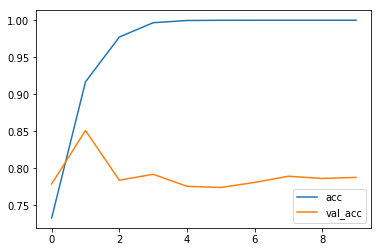

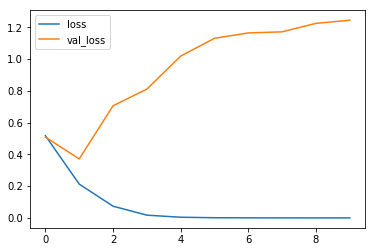

In [42]:
acc = history.history['acc']

plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [43]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print('Test accuracy: %f'%test_acc)

25000/25000 [==============================] - 2s 95us/step
Test accuracy: 0.844000


In [44]:
# 感觉训练过拟合了，或许去掉停用词效果会好些

#### 选择3：文章自动续写

在这个作业中你要完成一个文章自动续写的模型。

1.数据获取。（根据你的兴趣采用爬虫技术爬去相关网站上的文本数据内容：比如故事网站，小说网站等）

2.选取模型，并训练。

3.展示一些你模型的输出例子。